## ASTR 2100, Winter 2020

## Homework Assignment 1: Numerical integration (30 points)

### Khalil Sayid

In [64]:
from math import isclose
import numpy as np
import warnings
import matplotlib.pyplot as plt
import plot_utils
from HW01_starter import *


**Task 1a. (15 points)**
Implement a routine to compute $R_1(h)$ scheme using the efficient method desribed above and check it for a test function for which you know the integral exactly. Plot fractional error as a function of step size and demonstrate that the error in your implemented routine indeed scales as $\propto h^4$.

Implement capability of passing a pointer to a list of arguments <tt>*args</tt> to function that is integrated. Use my routines at the bottom of this notebook as an example. If these examples are not sufficiently clear, you can read more about this way of passing arguments <a href="https://www.python-course.eu/python3_passing_arguments.php">here</a>.

In [74]:
def R1(func, a, b, h, *args):
    '''
    Efficient Romberg Routine (as decribed in the homework)
    
    Inputs:
        func: function to integrate (with optional arguments *args)
        float a, float b: specifies the interval [a, b] to integrate over
        float h: step size
    Output:
        float
        
    Assumption: 
    The number of divisons j of the interval [a, b] as specified by the step-size h
    is a power of 2. If not, the function adjusts h accordingly and prints a warning.
    
    '''
    j = np.log2((b - a) / h)
    if not(isclose(j, int(j))): 
        #Assumption check! 
        #If the number of divisions j and int(j) are not within 1e-7% of each other
        j = int(j)
        h = (b - a) / 2 ** (j)
        warnings.warn("\nPower of 2 assumption violated: h --> {}".format(h))
    k = np.log2(2 * (b - a) / h)
    i = np.arange(1, pow(2, k - 1) + 1)
    x = a + (h / 2) * (2 * i - 1)
    vals = func(x, *args)
    return (1/3) * (trapzd(func, a, b, h, *args) + 2 * h * np.sum(vals))

In [3]:
R1(np.exp, 0, 1, .01)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: 
Power of 2 assumption violated: h --> 0.015625


1.7182818284946066

In [4]:
R1(np.exp, 0, 1, 2 ** -1)

1.718318841921747

**Explanation**: 

Given that $$\int_{0}^{1} e^{x} \,dx = e^{1} - 1 \approx 1.718, $$ we see that the R1 routine returns an accurate approximation of the definite integral. We also see that when the step-size does not correspond to a number of steps that is a power of 2, a warning is raised and the step-size is adjusted accordingly.

In [5]:
# Source: 02_integration_approximation.ipynb
def compute_integral(func, int_func, a, b, ns, *args):
    '''
    Description: Computes the integral of function func on interval [a, b]
    using the routine specified by the function int_func. The number of steps
    is specified by ns.
    
    Returns (array of definite integrals, array of step sizes)
    '''
    nsteps = np.arange(ns) # generate a vector of nstep values from 0 to ns-1
    rom_int_value = np.zeros(np.shape(nsteps)[0]) # initialize a vector for integration results for each step size
    bma = b - a
    hsteps = bma / np.power(2., nsteps) # compute vector of corresponding step sizes
    for i, ns in enumerate(nsteps):
        rom_int_value[i] = int_func(func, a, b, hsteps[i], *args) # compute the integral for each step size
     
    return rom_int_value, hsteps # return vectors of integration results and step sizes0 

In [6]:
def test_error(func, int_func, a, b, ns, exact, *args):
    '''
    Description: Plots the fractional error of R1 integration routine
    for a given function func on the interval [a, b]. Data points are 
    generated by applying this routine for different step sizes as 
    specified by ns, the number of steps. The exact value of the 
    integral is required as an input to find the fractional error.
    
    Yields: Fractional error plot.  
    
    Returns: None.
    
    Note: If the exact value of the integral is 0, a divide-by-zero
    error is raised. 
    '''
    rom_int_val, hsteps = compute_integral(func, int_func, a, b, ns, *args)
    trap_int_val, hsteps = compute_integral(func, trapzd, a, b, ns, *args)
    ferr_rom = np.abs(rom_int_val/exact - 1.)
    ferr_trap = np.abs(trap_int_val/exact - 1.)
    #model is ferr ~ h^4, we normalize it to the size of error for first step size in the sequence:
    ferr_model = ferr_rom[0] * (hsteps/hsteps[0])**4

    plot_utils.plot_line_points(np.log10(hsteps), np.log10(ferr_model), 
                     xlabel=r'$\log_{10}\,\rm step\ size$', ylabel = r'$\log_{10}\vert\rm fractional\ error\vert$',
                     xp=np.log10(hsteps), yp=np.log10(ferr_model), points=True, 
                     legend=r'${\rm scaling} \propto h^4$', plegend = r'$\rm measured\ error$',
                     legendloc = 'lower right', 
                     plot_title=r'$R_1\ \rm frac.\ error\ scaling\ with\ step\ size$',
                     grid=True, figsize=5, figsave='fracerr_r1.pdf')

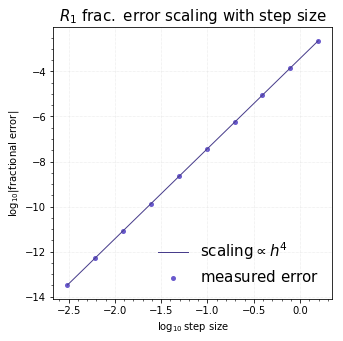

In [7]:
test_error(np.cos, R1, 0, np.pi / 2, 10, 1)

**Task 1b. (10 points)** Use the fact that $T(h)$ and $R_1(h)$ provide 2 estimates of the integral of different accuracy, implement a routine similar to above that can use the difference between $R_1(h)$ and $T(h)$ for steps of decreasing size to figure out what step $h$ to use to achieve input threshold values of the absolute tolerance <tt>atol</tt> and fractional accuracy <tt>rtol</tt>. Test your routine by computing an integral with different tolerance values and examining the fractional error relative to exact result. 

In [75]:
def R1_ideal_step(func, a, b, atol, rtol, *args):
    """
    Description: Find smallest step size (that is a power of 2) that
    satisfies the absolute tolerance and fractional accuracy thresholds. 
    """
    h = np.abs(b - a) 
    rom_int = R1(func, a, b, h, *args) 
    trap_int = trapzd(func, a, b, h, *args) 
    abs_error = np.abs(rom_int - trap_int) 
    rel_error = np.abs(1 - trap_int/rom_int) 

    while (abs_error >= atol) or (rel_error >= rtol):
        h = h / 2. #Make sure h step splits up our interval evenly
        rom_int = R1(func, a, b, h, *args)
        trap_int = trapzd(func, a, b, h, *args)
        abs_error = np.abs(rom_int - trap_int)
        if rom_int == 0:
            rel_error = 1e-300
        else:
            rel_error = np.abs(1 - trap_int/rom_int) 
        
    return h

In [76]:
def R1_improved(func, a, b, atol, rtol, *args):
    """
    Description: Returns approximate definite integral of function
    func on interval [a, b] that is within a given absolute tolerance
    atol and fractional tolerance rtol. 
    """
    h = R1_ideal_step(func, a, b, atol, rtol, *args)
    return R1(func, a, b, h, *args) 

In [10]:
def test_error(func, int_func, a, b, ns, exact, *args):
    '''
    Description: Plots the fractional error of R1 integration routine
    for a given function func on the interval [a, b]. Data points are 
    generated by applying this routine for different step sizes as 
    specified by ns, the number of steps. The exact value of the 
    integral is required as an input to find the fractional error.
    
    Yields: Fractional error plot.  
    
    Returns: None.
    
    Note: If the exact value of the integral is 0, a divide-by-zero
    error is raised. 
    '''
    rom_int_val, hsteps = compute_integral(func, int_func, a, b, ns, *args)
    trap_int_val, hsteps = compute_integral(func, trapzd, a, b, ns, *args)
    ferr_rom = np.abs(rom_int_val/exact - 1.)
    ferr_trap = np.abs(trap_int_val/exact - 1.)
    #model is ferr ~ h^4, we normalize it to the size of error for first step size in the sequence:
    ferr_model = ferr_rom[0] * (hsteps/hsteps[0])**4

    plot_utils.plot_line_points(np.log10(hsteps), np.log10(ferr_model), 
                     xlabel=r'$\log_{10}\,\rm step\ size$', ylabel = r'$\log_{10}\vert\rm fractional\ error\vert$',
                     xp=np.log10(hsteps), yp=np.log10(ferr_model), points=True, 
                     legend=r'${\rm scaling} \propto h^4$', plegend = r'$\rm measured\ error$',
                     legendloc = 'lower right', 
                     plot_title=r'$R_1\ \rm frac.\ error\ scaling\ with\ step\ size$',
                     grid=True, figsize=5, figsave='fracerr_r1.pdf')

In [11]:
def contour_error(func, int_func, a, b, mag1, mag2, exact, *args):
    """
    Produces Contour Error Plot
    Mag1, mag2 are orders of magnitude for the rel_err and abs_err
    thresholds.
    Exact is the exact value of the integral.
    """
    g = np.vectorize(int_func)
    rel_err = (1/10) ** np.arange(1, mag1 + 1, .5)
    abs_err = (1/10) ** np.arange(1, mag2 + 1, .5)
    X, Y = np.meshgrid(rel_err, abs_err)
    Z = g(func, a, b, X, Y, *args)
    Z = abs(Z / exact - 1)
    plt.contourf(np.log10(X), np.log10(Y), Z)
    plt.xlabel("Relative Error")
    plt.ylabel("Absolute Error")
    plt.title("Contour Plot: \n Accuracy Thresholds vs. Fractional Error")

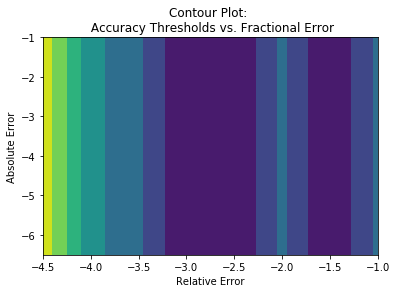

In [16]:
contour_error(np.exp, R1_improved, 10, 20, 4, 6, np.exp(20) - np.exp(10))

**Explanation**:

Above, we apply the improved Romberg routine to approximate $$\int_{10}^{20} e^{x} \,dx.$$ We do so using various thresholds for the relative and absolute errors, and we plot our results in a contour plot above. Here, we see that the accuracy improves as we increase the specified thersholds until floating point errors cause the accuracy to decrease.

**Task 1c. (5 points)**  Implement routine computing luminosity distance $d_L$ using the integration routine developed in the task 1a and 1b. For uniformity and ease of testing your routine, please keep the interfaces of your routines similar to my routines. However, if you implement 1b, add input parameters for <tt>atol</tt> and fractional accuracy <tt>rtol</tt>.

If you do not manage to get your implementation working, use my routine below for subsequent exercise 

In [77]:
def _dc_improved(z1, z2, atol, rtol, *args):
    """
    helper function to compute D_c from z1 to z2 by numerical integration using R1_improved
    
    Parameters: 
    -----------
    z1, z2: floats = redshift integration limits
    *args: argument list to pass to dl_func
    
    Returns:
    --------
    float - value of the integral estimated using R1_improved integration
    """
    return R1_improved(dl_func, z1, z2, atol, rtol, *args)

In [78]:
def d_L(z, H0, Om0, OmL, atol, rtol):
    '''
    routine computing luminosity distance from z=0 to z 
    using helper routine for comoving distance _dc
    
    Parameters:
    -----------
    z: float - redshift to which to compute d_L
    H0: float - Hubble constant in units of km/s/Mpc
    Om0: float - dimensionless mean matter density in the universe, >= 0
    OmL: float - dimensionless mean vacuum energy density in the universe
    atol: float = absolute error tolerance
    rtol: float = relative error tolerance
     
    Returns:
    --------
    float - value of d_L(z, H0, Om0, OmL)
    '''
    if 1.0 + OmL == 1.0: # note that I exploit the roundoff error in testing whether OmL is consistent with zero
        return d_L_simple(z, H0, Om0) # if OmL=0, use simple formula without integration
    else: # otherwise use numerical integration to compute distance 
        dH = clight / H0 
        Omk = 1.0 - Om0 - OmL
        args = [H0, Om0, OmL, Omk]
        dc = _dc_improved(0., z, atol, rtol, *args)
        if 1.0 + Omk == 1.0:
            return dH * dc * (1.0 + z)
        else:
            sqrOmk = np.sqrt(np.abs(Omk))
            if Omk > 0.:
                return dH * np.sinh(dc*sqrOmk) * (1.0 + z) / sqrOmk 
            else:
                return dH * np.sin(dc*sqrOmk) * (1.0 + z) / sqrOmk
        return dL

In [79]:
H0, Om0, OmL, z = 70., 0.3, 0.7, 2
atol, rtol = 1e-3, 1e-3
dL_improved = d_L(z, H0, Om0, OmL, atol, rtol)

print("d_L(z=%.2f, Om0=%.2f, OmL=%.2f, H0=%.1f) = %.4g Mpc" % (z, Om0, OmL, H0, dL_improved))


d_L(z=2.00, Om0=0.30, OmL=0.70, H0=70.0) = 1.554e+04 Mpc


**Task 1d. Extra-credit (10 points)** Implement a routine for computing $d_L$ based on the trapezoidal integration scheme that is 4th order accurate (i.e has fractional error scaling as $\propto h^4$) *without* using the formula $R_1(h)=[4T(h/2)-T(h)]/3$. Test your routine and demonstrate that its fractional error scales as $\propto h^4$ using a plot. 

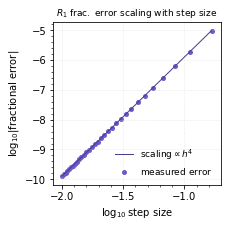

In [7]:
def trapzd3(func, a, b, nstep, vectorize = False):
    assert nstep % 3 == 0, "{} is not a multiple of 3".format(n)
    assert nstep >= 6, "{} must be greater than 3".format(n)
    
    bma = np.abs(b-a)
    
    if not(vectorize):
        func = np.vectorize(func)
    area = func(a) + func(b)  
    hstep = bma / nstep
    indices = np.arange(1, nstep)
    xd = a + indices * hstep # np.arange creates a vector of values from 0 to nstep-1
    mult = indices % 3 == 0
    xd_2, xd_3 = xd[~mult], xd[mult]
    area += 3 * np.sum(func(xd_2)) + 2 * np.sum(func(xd_3))
    area *= 3 * hstep / 8
    return area

def compute_integral2(func, int_func, a, b, ns):
    nsteps = np.arange(6, ns, 3) # generate a vector of nstep values from 0 to ns-1
    trint = np.zeros(np.shape(nsteps)[0]) # initialize a vector for integration results for each step size

    bma = b - a
    hsteps = bma / nsteps # compute vector of corresponding step sizes
    for i, ns in enumerate(nsteps):
        trint[i] = int_func(func, a, b, nsteps[i]) # compute the integral for each step size
     
    return trint, hsteps # return vectors of integration results and step sizes


a, b, ns, fexact = 0, 1, 100, np.exp(1) - 1
trint, hsteps = compute_integral2(np.exp, trapzd3, a, b, ns)

ferr = np.abs(trint/fexact - 1.)

#model is ferr ~ h^n, we normalize it to the size of error for first step size in the sequence:
ferr_model = ferr[0] * (hsteps/hsteps[0])**4

plot_utils.plot_line_points(np.log10(hsteps), np.log10(ferr_model), 
                 xlabel=r'$\log_{10}\,\rm step\ size$', ylabel = r'$\log_{10}\vert\rm fractional\ error\vert$',
                 xp=np.log10(hsteps), yp=np.log10(ferr), points=True, 
                 legend=r'${\rm scaling} \propto h^4$', plegend = r'$\rm measured\ error$',
                 legendloc = 'lower right', 
                 plot_title=r'$R_1\ \rm frac.\ error\ scaling\ with\ step\ size$',
                 grid=True, figsize=3, figsave='fracerr_r1.pdf')

## Exercise 2 (extra-credit)

Implement a routine performing Romberg integration of input function $f(x)$ and integration interval $[a,b]$ to a specified *fractional* error tolerance. Implement the integration routine in such a way that one can pass a list of parameter values of arbitrary size to $f(x)$ using <tt>*args</tt> pointer as in my routines below. 

The Romberg integration starts either with a step size equal to the entire integration interval ($h_0=b-a$) to compute $R_0(h_0)=T(h_0)$ and proceeds to estimate $R_m$ for $m=1,2,\ldots$ using equation derived in class: 

$$
R_{m+1}(h)=\frac{4^{m+1} R_{m}(h/2)-R_{m}(h)}{4^{m+1}-1}.
$$

One can implement this via recursive calls to the same function, but a much more efficient is to reuse computations done for $R_m(h)$ in computing $R_m(h/2)$. 


**Task 2a. (35 points)** Implement a routine that estimates integral $\int_a^b f(x)dx$ using Romberg integration method with error better than specified tolerance level, as in the task 1b above, but using $R_{m+1}$ and $R_{m}$ instead of $R_1$ and $T$. Test your routine by computing $$\int_0^1 e^x dx$$ for different tolerance levels and comparing results with the 
true value of the integral. 

**Intuition**: We acquire the idea for a Romberg Table from https://www.mathstat.dal.ca/~tkolokol/classes/2400/romberg.pdf . 
We see that storing iterations of the Romberg method would allow us to reuse computations, making our
algorithm more efficient.

In [115]:
def Romberg_helper(func, a, b, m, *args):
    """
    Description: Finds m-th and m - 1 th iteration of Romberg method
    in order to integrate a function func on the interval [a, b]. 
    
    func(**args) <-- arguments to pass into func
    
    """
    assert ((m >= 0) and (isinstance(m, int))), "m is ill-defined"
    assert (a < b), "interval is ill-defined"
    
    ### Initialize the Romberg Table with dimensions (m + 1) x (m + 1).
    Rom_table = np.zeros((m+1,m+1)) 
    
    ### We first calculate the first element of the Romberg Table
    ### This is Trapezoidal Rule on 1 sub-interval.
    h = (b - a) / 2 ** (np.arange(0, m + 1))
    Rom_table[0,0] = (b - a) / 2 * (func(a, *args) + func(b, *args))
        
    for i in range(1, m + 1):
        # Now, we compute R[i, 0] (the rest of the values in the
        # first column of the table).
        j = np.arange(1, 2**(i - 1) + 1)
        trap_sum = func(a + (2*j - 1)*h[i], *args).sum()
        
        # Now we apply the recurrence for the trapezoidal scheme,
        # as given at the beginning of the notebook. 
        # This completes R[i, 0]. 
        
        Rom_table[i, 0] = Rom_table[i - 1, 0] * 0.5 + h[i] * trap_sum
        
        # Now, we compute the terms along the diagonal of R[i, 0].
        # This uses the recurrence given in Exercise 2.
        
        for k in range(1, i + 1):
            coef = pow(4, k)
            Rom_table[i, k] = (coef * Rom_table[i, k - 1] - Rom_table[i - 1, k - 1]) / (coef - 1)
    
    # The table is complete. Return the mth and m - 1 th order approximation.

    return Rom_table[m, m], Rom_table[m, m - 1] 

def Romberg_recur(func, a, b, rtol = 1e-4, m = 5, verbose = False, *args):
    """
    Description: Integrates function func on interval [a, b] that satisfies
    a given fractional tolerance. Function ends when the fractional error
    is less than the tolerance rtol or when the maximum number of iterations
    max_iter is met.
    
    Set Verbose to True for debugging purposes. 
    
    Returns (estimate of integral, estimated fractional error). 
    """
    assert (m >= 0 and isinstance(m, int)), "m is ill-defined"
    assert (a < b), "interval is ill-defined"
    
    for m in range(1, m):
        Int_m, Int_m1 = Romberg_helper(func, a, b, m, *args)
            
        if Int_m == 0:
            Int_m = 1e-300
        
        frac_err = abs(1 - Int_m1 / Int_m)

        if verbose: 
            print("Order {}".format(m))
            print("Old Integral = {}".format(Int_m1))
            print("New Integral: {}".format(Int_m)) 
            print("Frac. Error Est.: {}".format(frac_err))
            print("\n")
        
        if frac_err < rtol:
            return Int_m, frac_err
        
    warnings.warn("\nMax iterations reached")
    return Int_m, frac_err
    

In [5]:
Romberg_recur(np.exp, 0, 1, verbose = True)

Order 1
Old Integral = 1.7539310924648253
New Integral: 1.7188611518765928
Frac. Error Est.: 0.02040300960315755


Order 2
Old Integral = 1.7183188419217472
New Integral: 1.7182826879247577
Frac. Error Est.: 2.1040773583669292e-05




(1.7182826879247577, 2.1040773583669292e-05)

**Task 2b. (5 points)** Implement a routine to compute luminosity distance $d_L$ using the integration routine developed in the task 2a. For uniformity and ease of testing your routine, please keep the interfaces of your routines similar to my routines. However, if you implement 1b, add input parameters for <tt>atol</tt> and fractional accuracy <tt>rtol</tt>.

In [130]:
def _dc_rom_recur(z1, z2, rtol, *args):
    """
    helper function to compute D_c from z1 to z2 by numerical integration using R1_improved
    
    Parameters: 
    -----------
    z1, z2: floats = redshift integration limits
    *args: argument list to pass to dl_func
    
    Returns:
    --------
    float - value of the integral estimated using R1_improved integration
    """

    return Romberg_recur(dl_func, z1, z2, rtol, 5, False, *args)[0]

In [128]:
def d_L_recur(z, H0, Om0, OmL, rtol):
    '''
    routine computing luminosity distance from z=0 to z 
    using helper routine for comoving distance _dc
    
    Parameters:
    -----------
    z: float - redshift to which to compute d_L
    H0: float - Hubble constant in units of km/s/Mpc
    Om0: float - dimensionless mean matter density in the universe, >= 0
    OmL: float - dimensionless mean vacuum energy density in the universe
    atol: float = absolute error tolerance
    rtol: float = relative error tolerance
     
    Returns:
    --------
    float - value of d_L(z, H0, Om0, OmL)
    '''

    if 1.0 + OmL == 1.0: # note that I exploit the roundoff error in testing whether OmL is consistent with zero
        return d_L_simple(z, H0, Om0) # if OmL=0, use simple formula without integration
    else: # otherwise use numerical integration to compute distance 
        dH = clight / H0 
        Omk = 1.0 - Om0 - OmL
        args = [H0, Om0, OmL, Omk]
        dc = _dc_rom_recur(0., z, rtol, *args)
        if 1.0 + Omk == 1.0:
            print("seq", dH, dc, z)
            return dH * dc * (1.0 + z)
        else:
            sqrOmk = np.sqrt(np.abs(Omk))
            if Omk > 0.:
                return dH * np.sinh(dc*sqrOmk) * (1.0 + z) / sqrOmk 
            else:
                return dH * np.sin(dc*sqrOmk) * (1.0 + z) / sqrOmk
        return dL

In [131]:
H0, Om0, OmL, z = 70, 0.3, 0.7, 2
rtol = 1e-3
dL_improved = d_L_recur(z, H0, Om0, OmL, rtol)

print("d_L(z=%.2f, Om0=%.2f, OmL=%.2f, H0=%.1f) = %.4g Mpc" % (z, Om0, OmL, H0, dL_improved))


a 0.0 b 2 rtol 0.001 m 5 verbose False
70 0.3 0.7 0.0 romberg_recur
seq 4282.7494 1.2092212877031825 2
d_L(z=2.00, Om0=0.30, OmL=0.70, H0=70.0) = 1.554e+04 Mpc


## Exercise 3 (extra-credit, 15 points)

Parallelize your Romberg integration routine with message passing interface (MPI) library by splitting integration interval into independent segments and applying Romberg integration on each one independently. I would be happy to go over basics of using MPI for basic parallelization with you, if you choose to do this exercise. You can also check out this tutorial on <a href="https://mpi4py.readthedocs.io/en/stable/tutorial.html">mpi4py</a>. You will need to have mpi4py installed on your laptop for this exercise or on a machine were you can run your code. Note that mpi4py is already installed if you installed the Ananconda python distribution. 

Test your implementation and check how its performance scales with a different number of processors. 

You can find example of parallel computation of integral with trapezoidal quadrature  <a href="http://materials.jeremybejarano.com/MPIwithPython/collectiveCom.html">here</a> that can be used as a template. 


**TBD**